In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import torch

import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd

In [2]:
def softmax(x):
    # x has shape [batch_size, n_classes]
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

# Load data

In [3]:
rvData = pd.read_csv("reviews.csv")
rvData['cleanReviews'] = rvData['reviews'].str.replace("[^a-zA-Z#]", " ") # remove special characters
docs = rvData['reviews']

# store each document with an initial id
docs = [(i, doc) for i, doc in enumerate(docs)]

# "integer -> word" decoder 
decoder = np.load('decoder.npy',allow_pickle=True)[()]

# for restoring document ids, "id used while training -> initial id"
doc_decoder = np.load('doc_decoder.npy',allow_pickle=True)[()]

In [73]:
# original document categories
# targets = dataset['target']
# target_names = dataset['target_names']
# targets = np.array([targets[doc_decoder[i]] for i in range(len(doc_decoder))])

# Load the trained model

In [4]:
state = torch.load('model_state.pytorch', map_location=lambda storage, loc: storage)
n_topics = 25

doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
resulted_word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()

# distribution over the topics for each document
topic_dist = softmax(doc_weights)

# vector representation of the documents
doc_vecs = np.matmul(topic_dist, topic_vectors)

# Show topics

In [5]:
similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

topic 1 : play get online account item family start character hacker share
topic 2 : family share play item account hacker way server cheater get
topic 3 : play get family share hacker way online account player item
topic 4 : online play make delete way get character system like thing
topic 5 : way get play family account share character control people option
topic 6 : delete get character player cheater year way item cheat play
topic 7 : play player way item easily get have cheater character try
topic 8 : play character get item online way hacker cheater inventory want
topic 9 : play family get share hacker mod account way online system
topic 10 : play get item online way player account hacker family share
topic 11 : get play cheater cheat online player way family hacker share
topic 12 : item play online hacker family get inventory share disable character
topic 13 : play get online hacker mod option item account easily player
topic 14 : get play item inventory cheater online force hac

# Show learned document embeddings

In [76]:
data = doc_vecs.astype('float64')
tsne = TSNE(n_jobs=4)
X = tsne.fit_transform(data)

TypeError: 'module' object is not callable

In [78]:
def plot(X):
    # X has shape [n_documents, 2]
    
    plt.figure(figsize=(16, 9), dpi=120);
    cmap = plt.cm.tab20
    number_of_targets = 20
    
    for i in range(number_of_targets):
        
        label = target_names[i]
        size = 15.0
        linewidths = 0.5
        edgecolors = 'k'
        color = cmap(i)
        
        if 'comp' in label:
            marker = 'x'
        elif 'sport' in label:
            marker = 's'
            edgecolors = 'b'
        elif 'politics' in label:
            marker = 'o'
            edgecolors = 'g'
        elif 'religion' in label:
            marker = 'P'
            size = 17.0
        elif 'sci' in label:
            marker = 'o'
            size = 14.0
            edgecolors = 'k'
            linewidths = 1.0
        elif 'atheism' in label:
            marker = 'P'
            size = 18.0
            edgecolors = 'r'
            linewidths = 0.5
        else:
            marker = 'v'
            edgecolors = 'm'
        
        plt.scatter(
            X[targets == i, 0], 
            X[targets == i, 1], 
            s=size, c=color, marker=marker,
            linewidths=linewidths, edgecolors=edgecolors,
            label=label
        );
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.3)

In [79]:
plot(X)  # learned document vectors

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

NameError: name 'X' is not defined

# Show initial document weights (vanilla lda)

In [13]:
doc_weights_init = np.load('doc_weights_init.npy')

In [81]:
tsne = TSNE(perplexity=200, n_jobs=4)
Y = tsne.fit_transform(doc_weights_init.astype('float64'))

TypeError: 'module' object is not callable

In [82]:
# to initialize topic assignments for lda2vec algorithm 
# I run normal LDA and used output distributions over topics 
# of each document

plot(Y)  # distribution over the topics for each document (output of LDA)

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

NameError: name 'Y' is not defined

# Explore learned topic distributions

In [ ]:
tsne = TSNE(perplexity=200, n_jobs=4)
Z = tsne.fit_transform(topic_dist.astype('float64'))

In [ ]:
plot(Z)  # learned distribution over the topics for each document

# these are topic assignments as on the plot above 
# but these ones are after the training of lda2vec

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

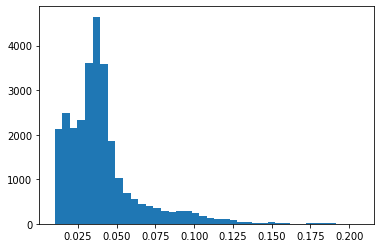

In [6]:
# distribution of nonzero probabilities
dist = topic_dist.reshape(-1)
plt.hist(dist[dist > 0.01], bins=40);

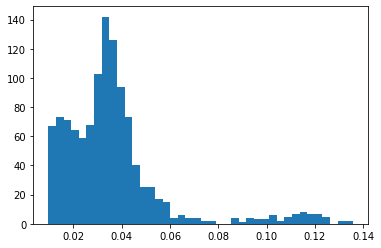

In [7]:
# distribution of probabilities for some random topic
plt.hist(topic_dist[:, 10], bins=40);

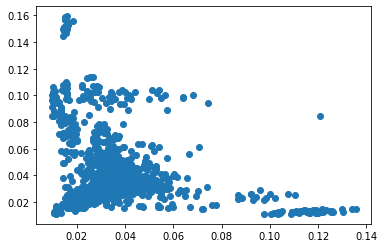

In [8]:
# topic assignments for two random topics
plt.scatter(topic_dist[:, 10], topic_dist[:, 20]);

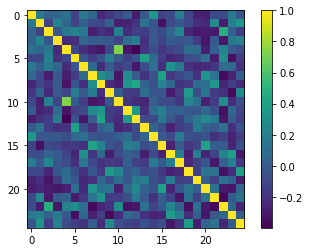

In [10]:
# correlation of topic assignments
corr = np.corrcoef(topic_dist.transpose(1, 0))
plt.imshow(corr);
plt.colorbar();

# Show a document and its topics

In [9]:
i = 100 # document id

print('DOCUMENT:')
print([doc for j, doc in docs if j == doc_decoder[i]][0], '\n')

print('DISTRIBUTION OVER TOPICS:')
s = ''
for j, p in enumerate(topic_dist[i], 1):
    s += '{0}:{1:.3f}  '.format(j, p)
    if j%6 == 0:
        s += '\n'
print(s)

print('\nTOP TOPICS:')
for j in reversed(topic_dist[i].argsort()[-3:]):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

DOCUMENT:
As long as legit players keep getting banned from the game and hackers go out unpunished, my review will stay negative.
Just wanted to have some fun playing with my friend because i kinda suck at this types of games untill some random chinese hacker summons me to his world and starts giving me items without even needing my acceptance. Just brute forcing players to accept this. So i ask.
Why am i getting punished for this? Why do i need to create another character and start over? After all the pain in the ass i had to just progress in the game? No, no and no. I won´t create another character, it is the DEV´s job to prevent this issues and not punish new players for their incompetence of having a decent anti-cheat. 

DISTRIBUTION OVER TOPICS:
1:0.022  2:0.020  3:0.025  4:0.028  5:0.026  6:0.030  
7:0.032  8:0.047  9:0.033  10:0.024  11:0.041  12:0.026  
13:0.072  14:0.036  15:0.023  16:0.022  17:0.024  18:0.060  
19:0.079  20:0.062  21:0.098  22:0.092  23:0.030  24:0.020  
25:0